# Covid Sales Prediction

### 목차

In [2]:
"""
각 컬럼들을 종합한 데이터를 만들고, 상관도를 구한다.
딥러닝 학습을 하면 테스트셋과 예측 결과의 정확도가 추출된다. (무엇의 정확도?)

"""

'\n각 컬럼들을 종합한 데이터를 만들고, 상관도를 구한다.\n딥러닝 학습을 하면 테스트셋과 예측 결과의 정확도가 추출된다. (무엇의 정확도?)\n\n'

### <화면 가로 확장>

In [3]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import h5py

### <GPU 확인>

In [8]:
tf.test.gpu_device_name()

'/device:GPU:0'

#### 최종 데이터 Import

In [9]:
Data_Combined=pd.read_csv('./Data/2021_Data_Combined.csv', encoding='cp949')
Data_Combined

,Unnamed: 0,날짜,확진자수(양성),검사수,확진자 증가량,검사수 증가량,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,0,20210101,61753,4269308,1027,55436,5,5,21,-4.2,0.0,0.0,2.0,0
1,1,20210102,62573,4302790,820,33482,5,5,21,-5.0,0.0,0.0,2.6,0
2,2,20210103,63230,4340830,657,38040,5,5,21,-5.6,0.0,0.0,2.0,0
3,3,20210104,64250,4376600,1020,35770,5,5,21,-3.5,0.0,0.0,1.7,249789
4,4,20210105,64964,4439352,714,62752,5,5,21,-5.5,0.0,0.0,2.9,211252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,321,20211118,406065,15845430,3290,3290,10,10,27,11.9,0.0,0.0,2.4,322402
322,322,20211119,409099,15848464,3034,3034,10,10,27,12.9,0.0,0.0,1.9,55371
323,323,20211120,412305,15851670,3206,3206,10,10,27,10.4,0.0,0.0,1.6,0
324,324,20211121,415425,15854790,3120,3120,10,10,27,10.4,1.0,5.9,1.9,0


### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [10]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_Combined.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['확진자수(양성)', '검사수', '확진자 증가량', '검사수 증가량', '18시 전 규제 인원수', '18시 후 규제 인원수', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)', '평균 풍속(m/s)', 'Won']
Data_scaled = scaler.fit_transform(Data_Combined[scale_cols])
Data_scaled = pd.DataFrame(Data_scaled)
Data_scaled.columns = scale_cols

Data_scaled.insert(0, '날짜', Data_Combined['날짜'])
Data_scaled

,날짜,확진자수(양성),검사수,확진자 증가량,검사수 증가량,18시 전 규제 인원수,18시 후 규제 인원수,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),평균 풍속(m/s),Won
0,20210101,0.000000,0.000000,0.246169,0.771646,0.0,0.285714,0.0,0.229614,0.0,0.000000,0.189189,0.000000
1,20210102,0.002300,0.002889,0.177215,0.457038,0.0,0.285714,0.0,0.212446,0.0,0.000000,0.351351,0.000000
2,20210103,0.004143,0.006172,0.122918,0.522355,0.0,0.285714,0.0,0.199571,0.0,0.000000,0.189189,0.000000
3,20210104,0.007004,0.009259,0.243837,0.489825,0.0,0.285714,0.0,0.244635,0.0,0.000000,0.108108,0.190575
4,20210105,0.009007,0.014674,0.141905,0.876487,0.0,0.285714,0.0,0.201717,0.0,0.000000,0.432432,0.161173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,20211118,0.965815,0.998948,1.000000,0.024376,1.0,1.000000,1.0,0.575107,0.0,0.000000,0.297297,0.245974
322,20211119,0.974325,0.999210,0.914724,0.020707,1.0,1.000000,1.0,0.596567,0.0,0.000000,0.162162,0.042245
323,20211120,0.983318,0.999487,0.972019,0.023172,1.0,1.000000,1.0,0.542918,0.0,0.000000,0.081081,0.000000
324,20211121,0.992070,0.999756,0.943371,0.021940,1.0,1.000000,1.0,0.542918,1.0,0.076227,0.162162,0.000000


### 5. 데이터 연관성 분석

In [11]:
Data_scaled.columns

Index(['날짜', '확진자수(양성)', '검사수', '확진자 증가량', '검사수 증가량', '18시 전 규제 인원수',
       '18시 후 규제 인원수', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)',
       '평균 풍속(m/s)', 'Won'],
      dtype='object')

In [12]:
import scipy.stats as stats

# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)
def P_value(dataset, c1, c2):
    Correlation=stats.pearsonr(dataset[c1], dataset[c2])
    print('< '+c1+'-'+c2+' >')
    print('P-value ==>> %.3f\n' %Correlation[1])

for p in range(1, len(Data_scaled.columns)-1):
    P_value(Data_scaled, Data_scaled.columns[p], 'Won')

< 확진자수(양성)-Won >
P-value ==>> 0.093

< 검사수-Won >
P-value ==>> 0.029

< 확진자 증가량-Won >
P-value ==>> 0.537

< 검사수 증가량-Won >
P-value ==>> 0.000

< 18시 전 규제 인원수-Won >
P-value ==>> 0.263

< 18시 후 규제 인원수-Won >
P-value ==>> 0.660

< 영업 제한 시각-Won >
P-value ==>> 0.079

< 평균기온(°C)-Won >
P-value ==>> 0.006

< 강수여부-Won >
P-value ==>> 0.061

< 일강수량(mm)-Won >
P-value ==>> 0.027

< 평균 풍속(m/s)-Won >
P-value ==>> 0.783



In [25]:
#Data_P = Data_scaled.drop([Data_scaled.columns[1], Data_scaled.columns[3], Data_scaled.columns[4], Data_scaled.columns[5], Data_scaled.columns[7], Data_scaled.columns[9]], axis=1)
Data_P = Data_scaled.loc[:, ['날짜', '검사수', '검사수 증가량', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)', 'Won']]

In [26]:
Data_P

,날짜,검사수,검사수 증가량,영업 제한 시각,평균기온(°C),강수여부,일강수량(mm),Won
0,20210101,0.000000,0.771646,0.0,0.229614,0.0,0.000000,0.000000
1,20210102,0.002889,0.457038,0.0,0.212446,0.0,0.000000,0.000000
2,20210103,0.006172,0.522355,0.0,0.199571,0.0,0.000000,0.000000
3,20210104,0.009259,0.489825,0.0,0.244635,0.0,0.000000,0.190575
4,20210105,0.014674,0.876487,0.0,0.201717,0.0,0.000000,0.161173
...,...,...,...,...,...,...,...,...
321,20211118,0.998948,0.024376,1.0,0.575107,0.0,0.000000,0.245974
322,20211119,0.999210,0.020707,1.0,0.596567,0.0,0.000000,0.042245
323,20211120,0.999487,0.023172,1.0,0.542918,0.0,0.000000,0.000000
324,20211121,0.999756,0.021940,1.0,0.542918,1.0,0.076227,0.000000


### 이상치 처리

In [12]:
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_40 = np.percentile(df[column].values, 40)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight
    
    midlow_val = quantile_40-IQR_weight
    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_midlow = df[column][df[column] < midlow_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    
    return outlier_index_low, outlier_index_high, quantile_25, quantile_50, quantile_75, outlier_index_midlow, quantile_40

In [58]:
print('Low Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[0]))
print('High Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[1]))
print('MidLow Outlier ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[5]))

print('25% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[2]))
print('40% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[6]))
print('50% Value ==>> {}\n'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[3]))
print('75% Value ==>> {}'.format(get_outlier(df=Data_P, column='Won', weight=1.5)[4]))

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([], dtype='int64')

MidLow Outlier ==>> Int64Index([], dtype='int64')

25% Value ==>> 0.0

40% Value ==>> 0.031305837886831146

50% Value ==>> 0.060951893395508105

75% Value ==>> 0.11444147382749494


In [14]:
"""
for sw in range(len(Data_P['Won'])):
    if (Data_P['Won'][sw]==0.000000):
        Data_P['Won'][sw]=get_outlier(df=Data_P, column='Won', weight=1.5)[6]
    else:
        pass
"""

"\nfor sw in range(len(Data_P['Won'])):\n    if (Data_P['Won'][sw]==0.000000):\n        Data_P['Won'][sw]=get_outlier(df=Data_P, column='Won', weight=1.5)[6]\n    else:\n        pass\n"

In [56]:
"""
high_val = get_outlier(df=Data_P, column='Won', weight=1.5)[1].values.tolist()

for l in range(len(high_val)):
    Data_P['Won'][high_val[l]] = get_outlier(df=Data_P, column='Won', weight=1.5)[4]
    """

C:\Users\82108\AppData\Local\Temp/ipykernel_12480/2761151136.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_P['Won'][high_val[l]] = get_outlier(df=Data_P, column='Won', weight=1.5)[4]


In [57]:
print('Quantity of Low Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=1.5)[0])))
print('Quantity of High Outlier ==>> {}\n'.format(len(get_outlier(df=Data_P, column='Won', weight=1.5)[1])))

Quantity of Low Outlier ==>> 0

Quantity of High Outlier ==>> 0



### 7. 데이터셋 편집

In [29]:
TEST_SIZE = 20  # 10일치를 테스트셋으로 사용
WINDOW_SIZE = 1 # 얼마 동안의 과거 기반의 데이터에 기반하여 다음날의 값을 예측할 것인지 설정. 

train = Data_P[:-TEST_SIZE]
test= Data_P[-TEST_SIZE:]

In [30]:
test = test.reset_index(drop=True) # 인덱스 초기화

In [31]:
from sklearn.model_selection import train_test_split

feature_cols = ['검사수', '검사수 증가량', '영업 제한 시각', '평균기온(°C)', '강수여부', '일강수량(mm)', 'Won']
label_cols = ['Won']

train_feature = train[feature_cols]
train_label = train[label_cols]

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, random_state=0, shuffle=False)

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
WINDOW_SIZE=1
BATCH_SIZE=128

In [34]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False) # 학습도 셔플 안해야 맞는게 아닌가??
valid_data = windowed_dataset(y_valid, WINDOW_SIZE, BATCH_SIZE, False)

In [35]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (128, 1, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (128, 1, 1)


### 8. 딥러닝 모델

In [66]:
"""
- initial_learning_rate : 최초의 학습률
- first_decay_steps : (첫 주기의 감쇄가 진행되는 총 스텝 수) 최초의 주기 길이
- t_mul : 주기 T를 늘려갈 비율 (첫 주기가 100step이면 그 다음은 200step, 그 다음은 400step...)
- m_mul : 최초 학습률로 설정한 값에 매 주기마다 곱해줄 값 (0.9라면 매 주기 시작마다 initial_learning_rate에 0.9 i
 (i는 주기 인덱스)만큼 곱한 값을 주기 시작 학습률로써 사용한다.)
- alpha : 학습률의 하한을 설정하기위한 파라미터로 학습률의 감소 하한은 initial_learning_rate * alpha가 된다.
"""

'\n- initial_learning_rate : 최초의 학습률\n- first_decay_steps : (첫 주기의 감쇄가 진행되는 총 스텝 수) 최초의 주기 길이\n- t_mul : 주기 T를 늘려갈 비율 (첫 주기가 100step이면 그 다음은 200step, 그 다음은 400step...)\n- m_mul : 최초 학습률로 설정한 값에 매 주기마다 곱해줄 값 (0.9라면 매 주기 시작마다 initial_learning_rate에 0.9 i\n (i는 주기 인덱스)만큼 곱한 값을 주기 시작 학습률로써 사용한다.)\n- alpha : 학습률의 하한을 설정하기위한 파라미터로 학습률의 감소 하한은 initial_learning_rate * alpha가 된다.\n'

In [67]:
lr_CosineDecay = tf.keras.experimental.CosineDecayRestarts(0.005, 5, t_mul=2.0, m_mul=0.9, alpha=0.2, name=None)

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from keras.layers.wrappers import TimeDistributed
from tensorflow.keras.utils import plot_model
import keras
    
model = Sequential([
    Conv1D(filters=32, kernel_size=1, padding="causal", input_shape=[WINDOW_SIZE, 1]),
    TimeDistributed(Dense(32)),
    Bidirectional(LSTM(16, return_sequences=True), merge_mode='concat'),
    Bidirectional(LSTM(16, return_sequences=True), merge_mode='concat'),
    LSTM(16, return_sequences = False),
    Dense(1)
                    ])

model.summary()

#Adam_Cosine = tf.keras.optimizers.Adam(learning_rate=lr_CosineDecay, amsgrad=False)
#model.compile(loss='mean_squared_error', optimizer=Adam_Cosine)
model.compile(loss='mean_squared_error', optimizer="Adam")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 32)             64        
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 32)            1056      
 tributed)                                                       
                                                                 
 bidirectional_2 (Bidirectio  (None, 1, 32)            6272      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 1, 32)            6272      
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                      

#### Plot model 저장

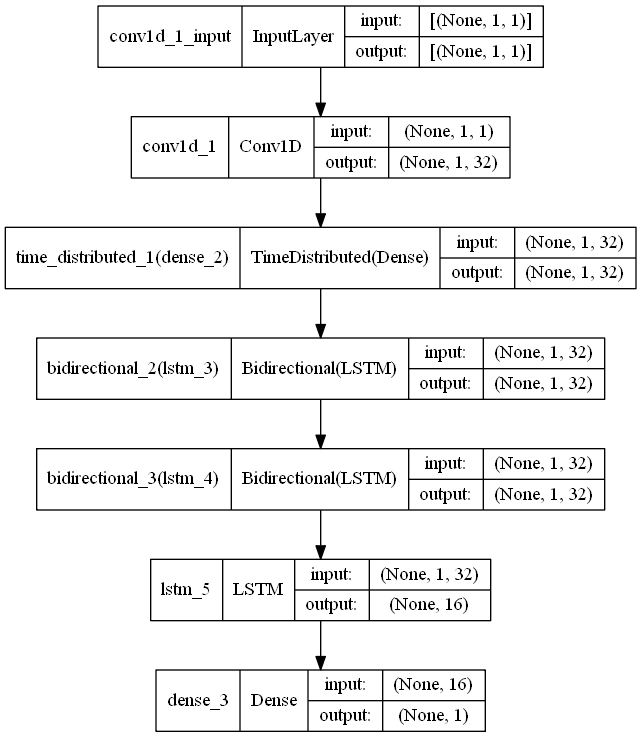

In [41]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_Covid.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=50, batch_size=32,validation_data=(valid_data), callbacks=[early_stop, checkpoint])

Epoch 1/50
      1/Unknown - 5s 5s/step - loss: 0.0384
Epoch 00001: val_loss improved from inf to 0.02330, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 6s 1s/step - loss: 0.0275 - val_loss: 0.0233
Epoch 2/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0370
Epoch 00002: val_loss improved from 0.02330 to 0.02234, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 82ms/step - loss: 0.0264 - val_loss: 0.0223
Epoch 3/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0357
Epoch 00003: val_loss improved from 0.02234 to 0.02144, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 81ms/step - loss: 0.0253 - val_loss: 0.0214
Epoch 4/50
1/2 [==============>...............] - ETA: 0s - loss: 0.0344
Epoch 00004: val_loss improved from 0.02144 to 0.02058, saving model to model\tmp_checkpoint_Covid.h5
2/2 [==============================] - 0s 85ms/step - loss: 0.0243

In [43]:
model.load_weights(filename)
pred = model.predict(test['Won'])

pred.shape

(20, 1)

### 9. 결과 표시

In [44]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


In [45]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

해당 폴더가 이미 존재합니다.


<function matplotlib.pyplot.show(close=None, block=None)>

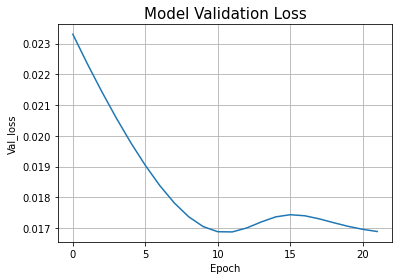

In [46]:
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

#### 성능 측정 지표

In [47]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

print('r2 >> %.4f' %r2(test['Won'], pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE(test['Won'], pred)) # 0에 가까워야 좋음
print('MSE >> %.4f' %MSE(test['Won'], pred)) # 0에 가까워야 좋음
print('RMSE >> %.4f' %np.sqrt(MSE(test['Won'], pred))) # 0에 가까워야 좋음
#print('RMSLE >> %.4f' %np.sqrt(MSLE(test['Won'], pred))) # 0에 가까워야 좋음

r2 >> 0.1177
MAE >> 0.0727
MSE >> 0.0093
RMSE >> 0.0963


In [48]:
RMSE = np.sqrt(MSE(test['Won'], pred))
RMSE_pct = round(1-RMSE, 5)*100
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

RMSE 측정 정확도 ==>> 90.370 %


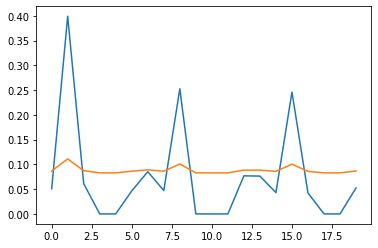

In [49]:
plt.plot(test['Won'])
plt.plot(pred)
plt.show()